# Sentiment Model Evaluation Notebook

In this notebook, I will benchmark the VADER, BERT and GPT-5.1 Models for their ability to identify sentiment of reddit data sourced from the r/nba subreddit

In [1]:
import sys
from pathlib import Path 

project_root = Path().resolve().parent  
sys.path.append(str(project_root))

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from src.preprocessing import read_data, clean_data
from src.model_vader import sent_analysis_vader
from src.model_openaiapi import sent_analysis_openai
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay


from transformers import BertForSequenceClassification, BertTokenizer
import torch
from tqdm import tqdm

/Users/aabirdatta/Desktop/Stuff/AutoInsights/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load labeled GoEmotions dataset
raw_data = "go_emotions_dataset.csv"
df_raw = read_data(raw_data)
df_true = clean_data(df_raw)

print(f"df shape: {df_true.shape}")
df_true.head()

df shape: (51576, 3)


,id,text,sentiment
0,eew5j0j,That game hurt.,negative
2,ed2mah1,"You do right, if you don't care then fuck 'em!",neutral
3,eeibobj,Man I love reddit.,positive
4,eda6yn6,"[NAME] was nowhere near them, he was by the Fa...",neutral
5,eespn2i,Right? Considering it’s such an important docu...,positive


In [4]:
# Load validation set from the r/nba subreddit
df_val = pd.read_csv('../data/nba_subreddit_sentanalysis.csv')
df_val = df_val.rename(columns={'body':'text', 'Human Sentiment Label':'sentiment'})

print(f"df shape: {df_val.shape}")
df_val.head()

df shape: (300, 3)


,subreddit,text,sentiment
0,nba,REPORT: Water is wet.,neutral
1,nba,*michael jackson popcorn gif*,neutral
2,nba,[the only reason anyone knows who Jared Dudley...,negative
3,nba,So you’d say 26 year old Buddy Hield isn’t a p...,neutral
4,nba,Oh I didn't know I was just going off that com...,neutral


### Helper Functions 

These functions modularize actions in this notebook.

In [5]:
def evaluate(df, pred_col):
    """
    This function computes the f1 score for model evaluation

    Input: 
        df: dataframe containing columns for both the model prediction and ground truth sentiment
        pred_col: column name that contains the sentiment predictions

    Output: 
        -F1 score 
        -Visual for confusion matrix
    """

    # Compute F1 score
    f1 = f1_score(df['sentiment'], df[pred_col], average='weighted')

    # create confusion matrix
    labels = ['positive', 'negative', 'neutral']
    con_matrix = confusion_matrix(df['sentiment'], df[pred_col],labels=labels)
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=con_matrix, display_labels=labels)

    return f1, cm_disp

In [6]:
def clean_oai_df(df, prompt, max_retries = 30, attempt = 0):
    """
    Reruns the OpenAI API calls for records with missing preditions (NaN) until all missing values are filled or the maximum retry limit is reached.

    Input: 
        df: validation dataset with sentiment predictions made by the GPT 5.1 model 
        prompt: Prompt for inference

    Output: complete dataset with missing values handled
    """

    # Iterate until prediction is made for all NaN records. Max attempts used to avoid inf loop
    while df['sentiment_pred_openai'].isna().sum() > 0 and attempt < max_retries:
        
        attempt += 1

        # Identiy missing (NaN) records, get total count and create boolean mask for NaN records
        missing_count = df['sentiment_pred_openai'].isna().sum()
        mask_df = df['sentiment_pred_openai'].isna()
        
        # Use boolean mask to get df subset with NaN records
        df_nan = df.loc[mask_df].copy()
        
        # Rerun OpenAI API call to generate sentiment prediction for missing records
        df_nan = df_nan.drop(columns=['input_text', 'sentiment_pred_openai'])
        df_new_pred = sent_analysis_openai(df_nan, prompt, batch_size=missing_count)

        # Update df
        cols_to_update = ['sentiment_pred_openai', 'input_text']
        df.loc[mask_df, cols_to_update] = df_new_pred[cols_to_update].values

        # Replace 'nan' with NaN
        df = df.replace('nan', np.nan)

    return df



In [7]:
def plot_class_imbalance(df, col_name, ds_name):

    order = ['positive','neutral','negative']

    # Plot bar chart
    counts = df[col_name].value_counts().reindex(order)
    plt.figure(figsize=(4, 3))
    plt.bar(counts.index, counts.values, color=['skyblue', 'lightgreen', 'salmon'])
    plt.xlabel('Sentiment Class', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.title(f'Class Imbalance for {ds_name}', fontsize=12)

    #  Add labels to the top of each bar
    for i, count in enumerate(counts.values):
        plt.text(i, count / 2, str(count), ha='center', va='center', fontweight='bold')

    return plt

### Exploratory Data Analysis

Let's start by exploring the GoEmotions and r/nba validation set.

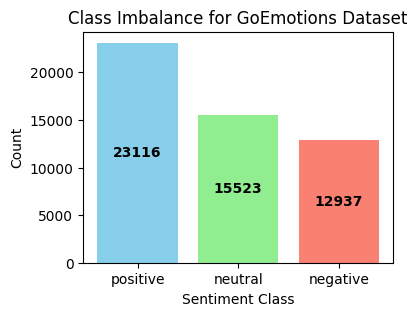

In [8]:
# Plot the class imbalance for the GoEmotions Dataset
ge_plt = plot_class_imbalance(df_true, 'sentiment', 'GoEmotions Dataset')
ge_plt.show()

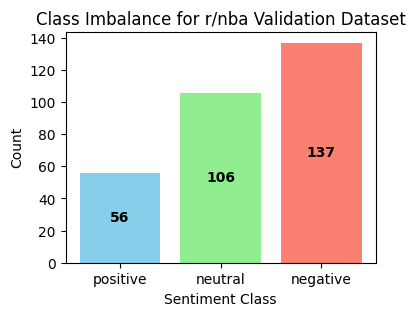

In [9]:
# Plot the class imbalance for the validation set
val_plt = plot_class_imbalance(df_val, 'sentiment', 'r/nba Validation Dataset')
val_plt.show()

We observe that the GoEmotions dataset has far more positive sentiment text compared to neutral and negative sentiment. By comparison, the r/nba validation set has more negative sentiment text compared to neutral and positive. This class imbalance will have to be accounted for when performing the sentiment analysis

### BERT Model

BERT (Bidirectional Encoder Representations from Transformers) is a pre-trained language model created by researchers at Google. For my sentiment analysis, I used Hugging Face’s Trainer class to fine-tune the model using 80% of the labeled dataset. Predictions on the test set were made using the remaining 20% and the saved results can be found in the go_emotions_bert_pred.csv file in the data directory. Note that this file was created by running the src/model_bert.py standalone script. 

As this analysis is a multi-class classification problem, I will evaluate the model performance primarily using F1 score. A confusion matrix will also be used to visualize the detailed, class-by-class breakdown of the model's performance, showing exactly which classes are correctly predicted and where it performed poorly.

In [10]:
# Load BERT predictions from the "data" directory
df_bert_pred = pd.read_csv('../data/go_emotions_bert_pred.csv')

print(f"Test set df shape: {df_bert_pred.shape}")

Test set df shape: (10316, 5)


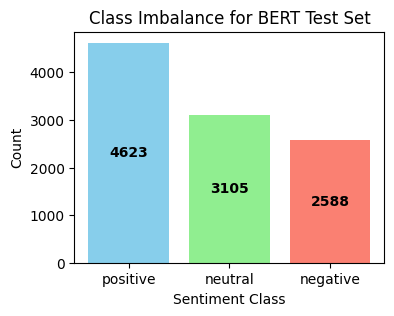

In [11]:
# Plot the class imbalance for the BERT test set
ge_ts_plt = plot_class_imbalance(df_bert_pred, 'sentiment', 'BERT Test Set')
ge_ts_plt.show()

Weighted F1 Score: 0.67


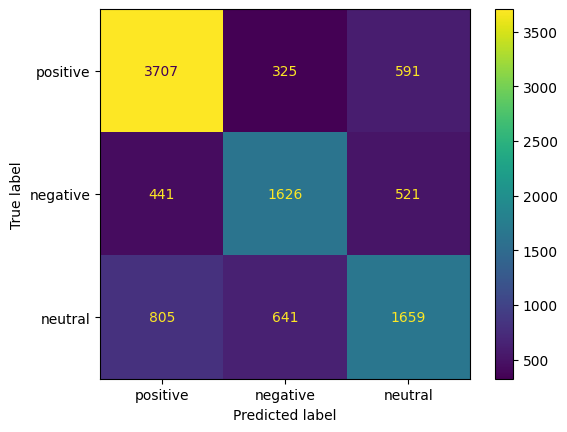

In [12]:
# Let's view F1 score and Confusion Matrix
bert_performance, bert_display = evaluate(df_bert_pred, pred_col = 'predicted_sentiment')

print(f"Weighted F1 Score: {bert_performance:.2f}")
bert_display.plot()

A weighted F1 score of 68% on the test set indicates that the BERT classifier fine tuned on the training data is able balance its precision and recall relatively well across on the reddit data (although there is certainly a lot of room for improvement). From the confusion matrix, we can observe that the model is able to correctly classify a majority of the true positive text as position, and perform resonably well at classifying the true negative and true neutral text correctly.

We'll now see how well the fine tuned model works on the validation set sourced from the r/nba subreddit. 

In [13]:
df_val_bert = df_val.copy()

# Load saved model and tokenizer
model_path = "../models/bert_sentiment_model"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

# Reverse your label mapping for decoding
id_to_label = {v: k for k, v in {'negative': 0, 'neutral': 1, 'positive': 2}.items()}

# Use the fine tuned model to make sentiment predictions on the validation set
def predict_sentiment(texts):
    """
    This function uses the fine tuned BERT model to make sentiment predictions

    Input: dataframe feature with reddit comment data

    Output: List of predicted sentiments
    """
    sentiments_list = []

    # for every record in the validation set, make a sentiment prediction (in record batches of 20)
    for i in tqdm(range(0, len(texts), 20)):

        # Tokenize batch
        batch = texts[i:i+20].tolist()
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")

        # Make sentiment predictions
        with torch.no_grad():
            outputs = model(**inputs)
            sentiment_scores = outputs.logits

            # Identify column with largest score. This is the predicted sentiment
            preds = torch.argmax(sentiment_scores, dim=1).tolist()

        sentiments_list.extend([id_to_label[p] for p in preds])

    return sentiments_list

# Save sentiment predictions
df_val_bert["predicted_sentiment"] = predict_sentiment(df_val_bert["text"])


100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


In [14]:
# Let's see first 5 records
df_val_bert.head()

,subreddit,text,sentiment,predicted_sentiment
0,nba,REPORT: Water is wet.,neutral,neutral
1,nba,*michael jackson popcorn gif*,neutral,neutral
2,nba,[the only reason anyone knows who Jared Dudley...,negative,neutral
3,nba,So you’d say 26 year old Buddy Hield isn’t a p...,neutral,neutral
4,nba,Oh I didn't know I was just going off that com...,neutral,positive


Weighted F1 Score: 0.51


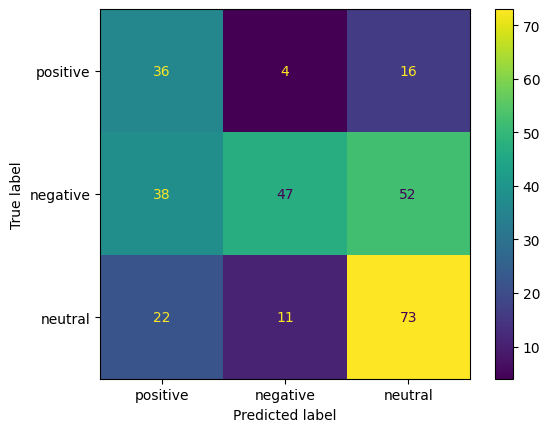

In [15]:
# Let's view F1 score and Confusion Matrix
df_val_bert['sentiment'] = df_val_bert['sentiment'].astype(str)
df_val_bert['predicted_sentiment'] = df_val_bert['predicted_sentiment'].astype(str)
bert_val_performance, bert_val_display = evaluate(df_val_bert, pred_col = 'predicted_sentiment')

print(f"Weighted F1 Score: {bert_val_performance:.2f}")
bert_val_display.plot()

We observe a weighted F1 score of 53% on the validation set, which is significantly lower than the model's performance on the test set (which was highly effective). This suggests that the model is suffering from a lack of generalization and may be overfitting to the training data. Better performance may be observed if the BERT model was fine tuned exclusively using data sourced from the r/nba subreddit, rather than the rich goemotions dataset.

### VADER

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a rule-based tool that leverages a predefined dictionary of words with sentiment scores. The tool uses simple rules to assign a sentiment score to a text, which can then be converted to a sentiment class of positive, negative, or neutral. Next, we will assess how well the VADER approach performs using the validation set.

In [16]:
# Make sentiment predictions using VADER
df_vader_pred = sent_analysis_vader(df_val)

print(f"df shape: {df_vader_pred.shape}")

df shape: (300, 4)


Weighted F1 Score: 0.49


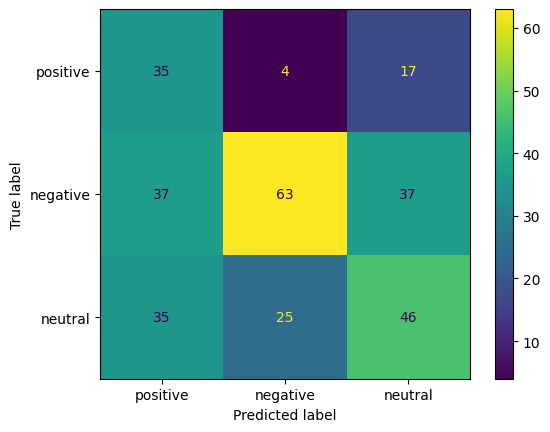

In [17]:
# Let's view F1 score and Confusion Matrix
df_vader_pred['sentiment'] = df_vader_pred['sentiment'].astype(str)
df_vader_pred['sentiment_score_vader'] = df_vader_pred['sentiment_score_vader'].astype(str)

vader_performance, vader_display = evaluate(df_vader_pred, pred_col = 'sentiment_score_vader')
print(f"Weighted F1 Score: {vader_performance:.2f}")
vader_display.plot()

When compared to the fine-tuned BERT model, the lexicon-based VADER approach performs worse than random guessing on the r/nba validation set, confirming its unsuitability for this domain due to its inability to learn contextual nuances found in this particular subreddit. From the confusion matrix, we can infer that the performance drop is likely the result of VADER's pre-defined dictionary exhibiting a positive bias, incorrectly classifying many of the true neutral and negative texts as positive. This bias highlights the effectiveness of using a machine learning approaches like BERT over lexicon-based approaches.

### GPT-5.1 Model

The last approach we will investigate involves leveraging GPT model 5.1 to classify the dataset entries as either positive, negative, or neutral, by leveraging the OpenAI API. This will involve two approaches:

1. Zero-Shot Approach: Label text with sentiment without providing any explicit labeled examples
2. Few-Shot Approach: Label text with sentiment using a few labeled examples for better in context learning specifically for the r/nba domain

Let's see how well this approach does on the validation set.

In [18]:
# Prompt for zero shot approach and no reference to domain
# Prompt generated using ChatGPT
prompt = (
    "You are a sentiment analyzer.\n"
    "Classify each text below as positive, negative, or neutral.\n"
    "Each input text is separated by '|||'.\n"
    "Return exactly one tuple for EACH input text, in the SAME ORDER.\n"
    "Each tuple must have this exact format: (original_text, sentiment_label)\n"
    "sentiment_label must be one of: positive, negative, neutral.\n"
    "Tuples must be separated by '|||'.\n"
    "Do NOT add or remove any text, punctuation, spaces, or line breaks.\n"
)

In [19]:
# Make sentiment predictions using the OpenAI API
df_oai = df_val.copy()
df_oai = df_oai[['subreddit','text','sentiment']]
df_oai_pred = sent_analysis_openai(df_oai, prompt, 10)
df_final_pred_oai = clean_oai_df(df_oai_pred, prompt)
print(df_final_pred_oai['sentiment_pred_openai'].value_counts(dropna=False))


sentiment_pred_openai
neutral     143
negative    109
positive     48
Name: count, dtype: int64


Weighted F1 Score: 0.732


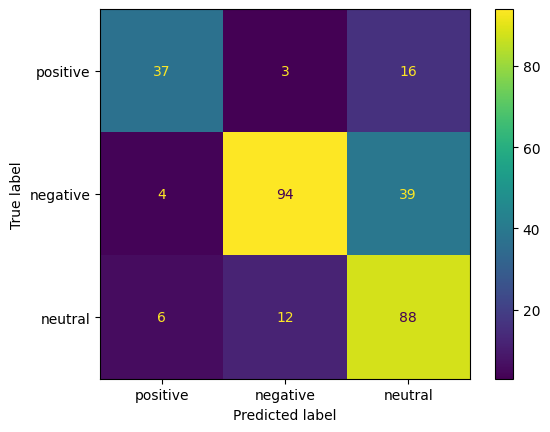

In [20]:
# Let's view F1 score and Confusion Matrix
df_final_pred_oai['sentiment'] = df_final_pred_oai['sentiment'].astype(str)
df_final_pred_oai['sentiment_pred_openai'] = df_final_pred_oai['sentiment_pred_openai'].astype(str)

oai_performance, oai_display = evaluate(df_final_pred_oai, pred_col = 'sentiment_pred_openai')
print(f"Weighted F1 Score: {oai_performance:.3f}")
oai_display.plot()

We observe that the zero shot GPT-5.1 model performs vastly better than the fine-tuned BERT model, yielding a F1 score of 73.5% on the validation set, compared to the 53% score of the BERT model. 

Let's now compare this to a few shot approach.  

In [21]:
# Now let's adjust the prompt to try a few shot approach. We will also specify the domain to further improve performance
# Prompt generated using ChatGPT
fewshot_prompt = (
    "You are a sentiment analyzer for NBA Reddit data.\n"
    "Your task is to classify text from the r/nba subreddit as positive, negative, or neutral. "
    "You must consider the specific context, slang, and common reddit opinions related to the NBA and its players/teams.\n"
    "\n"
    "--- Examples (Few-Shot Demonstrations) ---\n"
    "('That block by Wembanyama was absolutely insane, he’s going to be a problem for years.', positive)|||"
    "('The fourth quarter collapse by the Lakers was an absolute choke job. Fire the coach!', negative)|||"
    "('I think the trade was a decent move for both teams, nothing spectacular, just a salary dump.', neutral)|||"
    "('If Tatum gets over his inconsistency, he'll be a prolific 26 PPG+ player.', positive)|||"
    "('The Blazers' front office is a complete mess right now.', negative)\n"
    "--- End of Examples ---\n"
    "\n"
    "Classify each new input text below as positive, negative, or neutral.\n"
    "Each input text is separated by '|||'.\n"
    "Return exactly one tuple for EACH input text, in the SAME ORDER, following the examples above.\n"
    "Each tuple must have this exact format: (original_text, sentiment_label)\n"
    "sentiment_label must be one of: positive, negative, neutral.\n"
    "Tuples must be separated by '|||'.\n"
    "Do NOT add or remove any text, punctuation, spaces, or line breaks.\n"
)

In [22]:
# Make sentiment predictions using the OpenAI API 
df_oai_fs = df_val.copy()
df_oai_fs = df_oai_fs[['subreddit','text','sentiment']]
df_oai_fs_pred = sent_analysis_openai(df_oai_fs, fewshot_prompt, 10)
df_final_pred_fs_oai = clean_oai_df(df_oai_fs_pred, fewshot_prompt)
print(df_final_pred_fs_oai['sentiment_pred_openai'].value_counts(dropna=False))

sentiment_pred_openai
neutral     135
negative    108
positive     57
Name: count, dtype: int64


Weighted F1 Score: 0.758


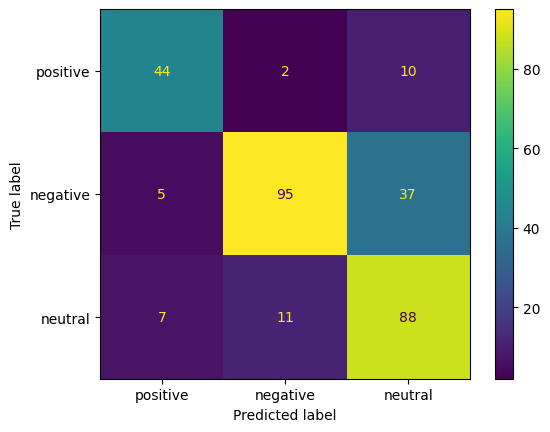

In [23]:
df_final_pred_fs_oai['sentiment'] = df_final_pred_fs_oai['sentiment'].astype(str)
df_final_pred_fs_oai['sentiment_pred_openai'] = df_final_pred_fs_oai['sentiment_pred_openai'].astype(str)

oai_fs_performance, oai_fs_display = evaluate(df_final_pred_fs_oai, pred_col = 'sentiment_pred_openai')
print(f"Weighted F1 Score: {oai_fs_performance:.3f}")
oai_fs_display.plot()

A few-shot approach with domain specified has resulted in further ~3% improvement in model performance.

In [24]:
df_final_pred_fs_oai = df_final_pred_fs_oai.rename(columns={'text':'comment','sentiment_pred_openai':'comment sentiment'})
df_final_pred_fs_oai = df_final_pred_fs_oai[['subreddit','comment','comment sentiment']]

output_path = "../data/nba_subreddit_sentanalysis_final.csv"
df_final_pred_fs_oai.to_csv(output_path, index=False)

print("File exported")

File exported


### Model Benchmarking Performance and Visualization

Let's now visually summarize the differences in model performance.

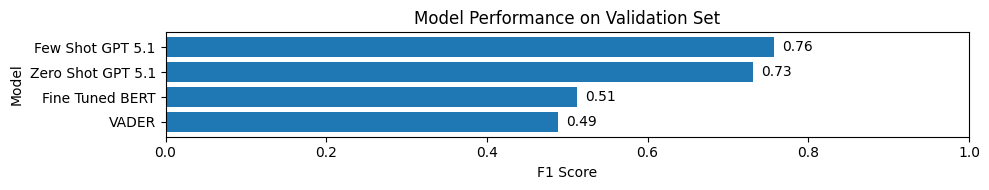

In [25]:
# Create df for model F1 scores
benchmark_data = {
    'Model': ['VADER', 'Fine Tuned BERT', 'Zero Shot GPT 5.1', 'Few Shot GPT 5.1'],
    'F1 Score': [vader_performance, bert_val_performance, oai_performance, oai_fs_performance]
}
bm_df = pd.DataFrame(benchmark_data)
bm_df = bm_df.sort_values(by='F1 Score', ascending=True)

# Plot horizontal bar chart
plt.figure(figsize=(10, 2))
bars = plt.barh(bm_df['Model'], bm_df['F1 Score'])
plt.xlabel('F1 Score')
plt.ylabel('Model')
plt.title('Model Performance on Validation Set')
plt.xlim(0.0, 1.0)

# Add label to bar
for bar in bars:
    xval = bar.get_width()
    # Place label slightly to the right
    plt.text(xval + 0.01, bar.get_y() + bar.get_height()/2, round(xval, 2), ha='left', va='center', fontsize=10)

plt.tight_layout()

(0.0, 12.75)

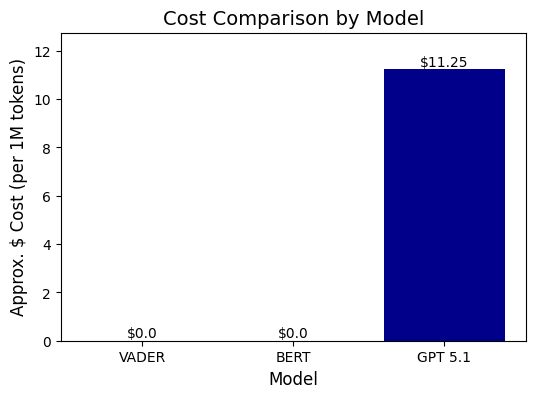

In [26]:
# Create cost df
cost_data = {
    'Model': ['VADER', 'BERT', 'GPT 5.1'],
    'Cost': [0, 0, 11.25]
}
cost_df = pd.DataFrame(cost_data)

# Plot bar chart
plt.figure(figsize=(6, 4))
plt.bar(cost_df['Model'], cost_df['Cost'], color='darkblue')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Approx. $ Cost (per 1M tokens)', fontsize=12)
plt.title('Cost Comparison by Model', fontsize=14)

 #  Add labels to the top of each bar
for i, count in enumerate(cost_df['Cost']):
    plt.text(i, count, f"${count}", ha='center', va='bottom')

# Add padding
plt.ylim(0, cost_df['Cost'].max()+1.5)
